# Media Analysis Challenge - Complete Notebook

This notebook addresses all 7 challenges for analyzing media data:
1. Data Cleaning
2. Sentiment Analysis
3. Trend Visualization
4. Topic Identification
5. Word Cloud Visualization
6. Summary Insights
7. Export Results

## Setup and Imports

In [62]:
#pip install jupyter pandas matplotlib seaborn textblob wordcloud numpy scikit-learn plotly openpyxl   

# Additional libraries for report generation (run on terminal)

pip install nbconvert nbconvert[webpdf] playwright

playwright install chromium

In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For sentiment analysis
from textblob import TextBlob

# For trendlines
from matplotlib.ticker import MaxNLocator

# For word clouds
from wordcloud import WordCloud

# For topic analysis
from collections import Counter
import re

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

import os
matplotlib_figs = []
plotly_figs = []

## Challenge 1: Data Cleaning (Foundation)

Time Allocation: 1-1.5 hours

In [64]:
#Convert xlsx to csv for better handling
pd.read_excel("Department of National Defense.xlsx").to_csv("Department of National Defense.csv", index=False)


In [65]:
import pandas as pd
import psutil
import gc

chunk_size = 10000

columns_to_keep = [
    'Date', 'Headline','Opening Text', 'Hit Sentence', 'URL', 'Source', 'Nation', 'Sentiment',
    'Keywords', 'Key Phrases', 'Desktop Reach', 'Mobile Reach'
]

critical_fields = ['Date', 'Headline', 'Source']

output_file = "cleaned_output.csv"

print("Loading and filtering data in chunks...")

for i, chunk in enumerate(pd.read_csv(
    "Department of National Defense.csv",
    chunksize=chunk_size,
    usecols=columns_to_keep
)):
    before_filter = len(chunk)
    
    # Remove rows with missing critical fields
    chunk = chunk.dropna(subset=critical_fields)
    
    # Remove very short headlines
    chunk = chunk[chunk['Headline'].str.len() > 10]
    
    # Convert Date to datetime
    chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce')
    
    # Drop rows with invalid/unparseable dates
    chunk = chunk.dropna(subset=['Date'])
    
    # Create date component columns
    chunk['Year'] = chunk['Date'].dt.year
    chunk['Month'] = chunk['Date'].dt.month
    chunk['Day'] = chunk['Date'].dt.day
    chunk['DayOfWeek'] = chunk['Date'].dt.day_name()
    chunk['MonthName'] = chunk['Date'].dt.month_name()
    
    print(f"Chunk {i+1}: {before_filter - len(chunk)} records removed")
    
    # Append to CSV directly
    mode = "w" if i == 0 else "a"   # overwrite on first chunk, append later
    header = (i == 0)               # write header only once
    chunk.to_csv(output_file, mode=mode, index=False, header=header)
    
    # Free memory
    del chunk
    gc.collect()
    
    # Memory monitoring
    process = psutil.Process()
    rss_mb = process.memory_info().rss / (1024 ** 2)
    print(f"  Process memory usage after chunk {i+1}: {rss_mb:.2f} MB")

print("All chunks cleaned and saved.")

# Load final cleaned dataset if needed
df = pd.read_csv(output_file)
print(f"Final cleaned dataset size: {len(df)}")


Loading and filtering data in chunks...
Chunk 1: 454 records removed
  Process memory usage after chunk 1: 373.52 MB
All chunks cleaned and saved.
Final cleaned dataset size: 783


In [66]:
# Explore data structure
print("Dataset Info:")
df.info()
print("\n" + "="*50 + "\n")
print("First 5 rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           783 non-null    object 
 1   Headline       783 non-null    object 
 2   URL            783 non-null    object 
 3   Opening Text   759 non-null    object 
 4   Hit Sentence   782 non-null    object 
 5   Source         783 non-null    object 
 6   Nation         783 non-null    object 
 7   Desktop Reach  476 non-null    float64
 8   Mobile Reach   476 non-null    float64
 9   Sentiment      720 non-null    object 
 10  Key Phrases    694 non-null    object 
 11  Keywords       783 non-null    object 
 12  Year           783 non-null    int64  
 13  Month          783 non-null    int64  
 14  Day            783 non-null    int64  
 15  DayOfWeek      783 non-null    object 
 16  MonthName      783 non-null    object 
dtypes: float64(2), int64(3), object(12)
memo

,Date,Headline,URL,Opening Text,Hit Sentence,Source,Nation,Desktop Reach,Mobile Reach,Sentiment,Key Phrases,Keywords,Year,Month,Day,DayOfWeek,MonthName
0,2025-07-31 23:09:00,Phl hastens AFP modernization amid rising secu...,https://tribune.net.ph/2025/07/31/phl-hastens-...,Photograph courtesy of DND/FB The Philippines ...,Photograph courtesy of DND/FB The Philippines ...,The Daily Tribune,Philippines,100764.0,445531.0,Neutral,"afp modernization,agencies,defense chief,high-...","Philippines,DND",2025,7,31,Thursday,July
1,2025-07-31 19:55:00,Manila's third phase of its military moderniza...,http://www.facebook.com/795355409480882,Department of National Defense - Philippines a...,Department of National Defense - Philippines a...,Facebook,Philippines,NaN,NaN,Neutral,NaN,"Department of National Defense,Philippines",2025,7,31,Thursday,July
2,2025-07-31 18:53:00,Why The DND Wants a Revamped Military Moderniz...,https://www.esquiremag.ph/politics/news/dnd-se...,Manila's third phase of its military moderniza...,... waterway. The Philippines has failed to en...,Esquire,Philippines,68736.0,110316.0,Negative,"country,cyber systems,defense chief,defense se...","Philippines,DND",2025,7,31,Thursday,July
3,2025-07-31 17:24:00,Gibo pushes faster AFP modernization to counte...,https://tribune.net.ph/2025/07/31/gibo-pushes-...,FILE PHOTO: Secretary of National Defense Gilb...,... : Secretary of National Defense Gilbert “G...,The Daily Tribune,Philippines,100764.0,445531.0,Neutral,"armed forces members,chinese government,countr...","Philippines,Department of National Defense,DND",2025,7,31,Thursday,July
4,2025-07-31 17:23:00,IKAGULAT NG LAHAT 😱!GABINETE NI PBBM NAGSAMA-S...,https://www.youtube.com/watch?v=0MKsDjsjvPI,... #philippines #bbm #bagongpilipinas #sara #...,#philippines #bbm #bagongpilipinas #sara #pbbm...,Youtube,Unknown,NaN,NaN,NaN,NaN,"philippines,dnd",2025,7,31,Thursday,July


In [67]:
# Check for missing values
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
                      Column  Missing_Count  Missing_Percentage
Mobile Reach    Mobile Reach            307           39.208174
Desktop Reach  Desktop Reach            307           39.208174
Key Phrases      Key Phrases             89           11.366539
Sentiment          Sentiment             63            8.045977
Opening Text    Opening Text             24            3.065134
Hit Sentence    Hit Sentence              1            0.127714


In [68]:
# Store initial count
initial_count = len(df)

# Handle duplicates after chunks are concatenated to avoid cross-chunk duplicates
print(f"Checking for duplicates...")

# Check duplicates by URL
url_duplicates = df.duplicated(subset=['URL'], keep='first').sum()
print(f"Duplicates by URL: {url_duplicates}")

# Check duplicates by Headline
headline_duplicates = df.duplicated(subset=['Headline'], keep='first').sum()
print(f"Duplicates by Headline: {headline_duplicates}")

# Check duplicates by URL and Headline combination
combined_duplicates = df.duplicated(subset=['URL', 'Headline'], keep='first').sum()
print(f"Duplicates by URL & Headline: {combined_duplicates}")

# Remove duplicates based on URL (keeping first occurrence)
df = df.drop_duplicates(subset=['URL'], keep='first')
print(f"\nRecords after removing URL duplicates: {len(df)}")
print(f"Removed {initial_count - len(df)} duplicate records")

Checking for duplicates...
Duplicates by URL: 27
Duplicates by Headline: 241
Duplicates by URL & Headline: 27

Records after removing URL duplicates: 756
Removed 27 duplicate records


In [69]:
# Normalize source names
print("Normalizing source names...")

# Check current source distribution
print(f"Unique sources before normalization: {df['Source'].nunique()}")
print("\nTop 10 sources:")
print(df['Source'].value_counts().head(10))

# Create normalization function
def normalize_source(source):
    if pd.isna(source):
        return source
    
    # Convert to string and lowercase
    source = str(source).lower().strip()
    
    # Remove common suffixes
    source = source.replace('.com', '').replace('.org', '').replace('.net', '')
    source = source.replace('www.', '')
    
    # Standardize common sources
    source_mapping = {
        'bbc': 'BBC',
        'reuters': 'Reuters',
        'bloomberg': 'Bloomberg',
        'the guardian': 'The Guardian',
        'guardian': 'The Guardian',
        'nytimes': 'New York Times',
        'ny times': 'new york times',
        'new york times': 'new york times',
        'reddit': 'Reddit',
        'yahoo': 'Yahoo! News',
        'gma': 'GMA News',
        'abscbn': 'ABS-CBN News',
        'abs cbn': 'ABS-CBN News',
        'abs-cbn': 'ABS-CBN News',
        'msn philippines': 'MSN Philippines',
    }
    
    for key, value in source_mapping.items():
        if key in source:
            return value
    
    return source.title()  # Title case for consistency

# Apply normalization
df['Source_Normalized'] = df['Source'].apply(normalize_source)

print(f"\nUnique sources after normalization: {df['Source_Normalized'].nunique()}")
print("\nTop 10 normalized sources:")
print(df['Source_Normalized'].value_counts().head(10))

Normalizing source names...
Unique sources before normalization: 180

Top 10 sources:
Source
Facebook                     105
Youtube                       63
MSN Philippines               59
The Daily Tribune             26
Blogs                         21
Philippine Daily Inquirer     21
Manila Standard               20
Manila Bulletin               19
The Philippine Star           17
Philippines News Digest       15
Name: count, dtype: int64

Unique sources after normalization: 148

Top 10 normalized sources:
Source_Normalized
Facebook                     105
Reddit                        83
Youtube                       63
MSN Philippines               59
The Daily Tribune             26
Blogs                         21
Philippine Daily Inquirer     21
Manila Standard               20
Manila Bulletin               19
The Philippine Star           17
Name: count, dtype: int64


In [70]:
# Data Cleaning Summary Report
print("\n" + "="*50)
print("DATA CLEANING SUMMARY REPORT")
print("="*50)
print(f"Initial record count: {initial_count}")
print(f"Duplicates removed: {initial_count - before_filter}")
print(f"Invalid/incomplete records removed: {before_filter - len(df)}")
print(f"Final record count: {len(df)}")
print(f"Total records removed: {initial_count - len(df)} ({((initial_count - len(df))/initial_count)*100:.1f}%)")
print("\nCleaning steps performed:")
print("1. Removed duplicate URLs")
print("2. Standardized date formats and created date components")
print("3. Normalized source names")
print("4. Filtered out records missing critical fields")
print("5. Removed records with invalid/test data")
print("="*50)


DATA CLEANING SUMMARY REPORT
Initial record count: 783
Duplicates removed: -454
Invalid/incomplete records removed: 481
Final record count: 756
Total records removed: 27 (3.4%)

Cleaning steps performed:
1. Removed duplicate URLs
2. Standardized date formats and created date components
3. Normalized source names
4. Filtered out records missing critical fields
5. Removed records with invalid/test data


## Challenge 2: Sentiment Analysis (Core Analytics)

Time Allocation: 1-1.5 hours

Existing sentiment counts:
Sentiment
Neutral     523
Positive     95
Negative     75
Missing      63
Name: count, dtype: int64


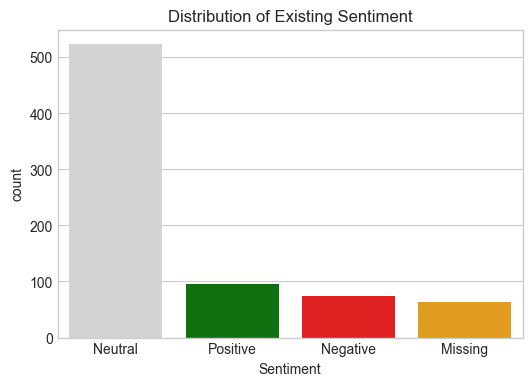


Comparison between existing and auto sentiment:
Auto_Sentiment  Negative  Neutral  Positive
Sentiment                                  
Negative              21       40        14
Neutral               57      355       111
Positive               6       65        24


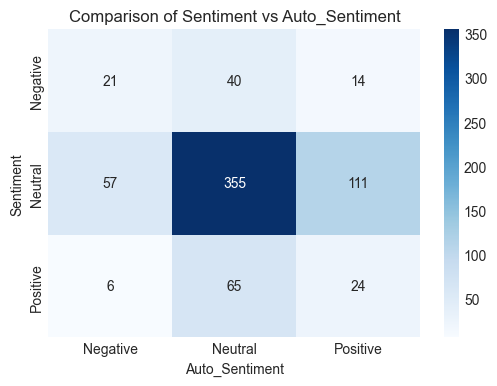

In [71]:
# Analyse existing Sentiment column
if "Sentiment" in df.columns:
    # Replace NaN with a label "Missing" just for plotting
    df_plot = df.copy()
    df_plot["Sentiment"] = df_plot["Sentiment"].fillna("Missing")

    sentiment_counts = df_plot["Sentiment"].value_counts()
    print("Existing sentiment counts:")
    print(sentiment_counts)

    # Define custom colours (including Missing)
    sentiment_colors = {
        "Positive": "green",
        "Negative": "red",
        "Neutral": "lightgray",
        "Missing": "orange"
    }

    # Visualise distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df_plot,
        x="Sentiment",
        order=sentiment_counts.index,
        palette=sentiment_colors
    )
    plt.title("Distribution of Existing Sentiment")
    plt.show()

# Use TextBlob to analyse Headlines
def get_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

df["Auto_Sentiment"] = df["Headline"].apply(get_sentiment)


# Compare Auto vs Existing Sentiment

if "Sentiment" in df.columns:
    comparison = pd.crosstab(df["Sentiment"], df["Auto_Sentiment"])
    print("\nComparison between existing and auto sentiment:")
    print(comparison)

    # Visualise with heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(comparison, annot=True, cmap="Blues", fmt="d")
    plt.title("Comparison of Sentiment vs Auto_Sentiment")
    matplotlib_figs.append(plt.gcf())
    plt.show()
    

# -----------------------------
# Extra: Visualise Auto Sentiment Distribution
# -----------------------------
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -----------------------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define colour mapping
sentiment_colors = {
    "Negative": "red",
    "Positive": "green",
    "Neutral": "lightgray"
}

# -----------------------------
# Pie Charts for Sentiment Comparison
# -----------------------------
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Existing Sentiment", "Auto Sentiment"),
    specs=[[{"type": "domain"}, {"type": "domain"}]]
)

# Existing Sentiment (if available)
if "Sentiment" in df.columns:
    sentiment_counts = df["Sentiment"].value_counts()
    fig.add_trace(
        go.Pie(
            labels=sentiment_counts.index,
            values=sentiment_counts.values,
            name="Existing Sentiment",
            marker=dict(colors=[sentiment_colors.get(label, "lightgray") for label in sentiment_counts.index])
        ),
        row=1, col=1
    )

# Auto Sentiment
auto_counts = df["Auto_Sentiment"].value_counts()
fig.add_trace(
    go.Pie(
        labels=auto_counts.index,
        values=auto_counts.values,
        name="Auto Sentiment",
        marker=dict(colors=[sentiment_colors.get(label, "lightgray") for label in auto_counts.index])
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    title_text="Sentiment Distribution Comparison",
    showlegend=True
)

fig.show()
plotly_figs.append(fig)


In [72]:
# Compare manual vs automated sentiment
# Only compare where manual sentiment exists
comparison_df = df[df['Sentiment'].notna()].copy()

# Create comparison
comparison_df['Match'] = comparison_df['Sentiment'] == comparison_df['Auto_Sentiment']

# Calculate match statistics
total_compared = len(comparison_df)
matches = comparison_df['Match'].sum()
mismatches = total_compared - matches

print(f"Sentiment Comparison Results:")
print(f"Total records compared: {total_compared}")
print(f"Matches: {matches} ({(matches/total_compared)*100:.1f}%)")
print(f"Mismatches: {mismatches} ({(mismatches/total_compared)*100:.1f}%)")

# Show examples where sentiments differ
print("\n5 Examples where Manual and Auto Sentiment Differ:")
print("="*80)

mismatched = comparison_df[~comparison_df['Match']].head(5)
for idx, row in mismatched.iterrows():
    print(f"\nHeadline: {row['Headline'][:100]}...")
    print(f"Manual Sentiment: {row['Sentiment']}")
    print(f"Auto Sentiment: {row['Auto_Sentiment']}")
    print("-"*80)

Sentiment Comparison Results:
Total records compared: 693
Matches: 400 (57.7%)
Mismatches: 293 (42.3%)

5 Examples where Manual and Auto Sentiment Differ:

Headline: Manila's third phase of its military modernization plan is called “Horizons” as the country has earm...
Manual Sentiment: Neutral
Auto Sentiment: Positive
--------------------------------------------------------------------------------

Headline: Why The DND Wants a Revamped Military Modernization Plan...
Manual Sentiment: Negative
Auto Sentiment: Neutral
--------------------------------------------------------------------------------

Headline: Gibo pushes faster AFP modernization to counter new threats...
Manual Sentiment: Neutral
Auto Sentiment: Positive
--------------------------------------------------------------------------------

Headline: DND, AFP welcome Nafarrete as new Philippine Army chief...
Manual Sentiment: Neutral
Auto Sentiment: Positive
--------------------------------------------------------------------

## Challenge 3: Trend Visualization (Time Series Analysis)

Time Allocation: 1-1.5 hours

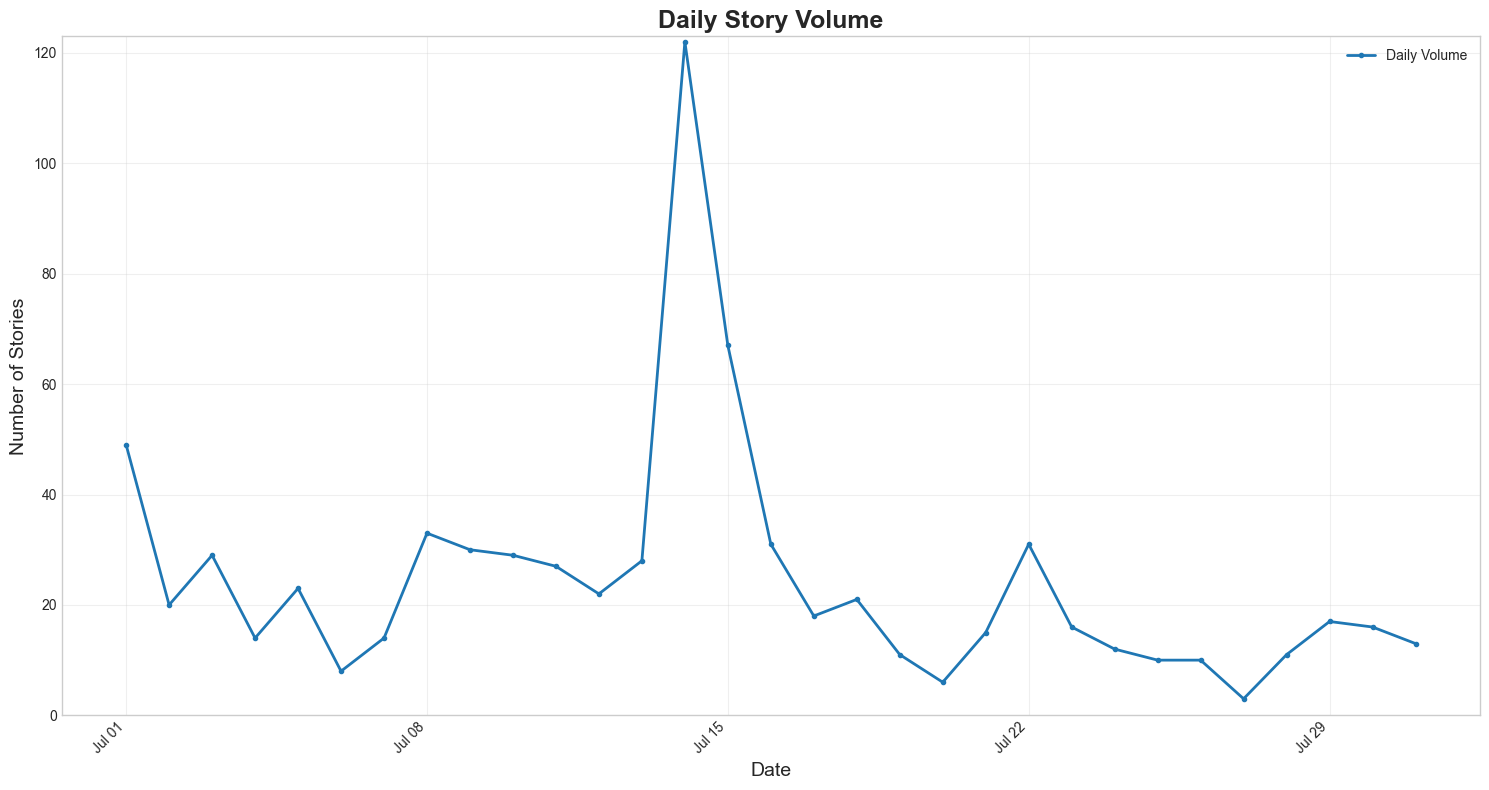

In [73]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1) Parse and clean dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()
df = df.loc[df['Date'].notna()]

# 2) Add Year/Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# 3) Daily counts
daily_volume = (
    df.groupby('Date')
    .size()
    .reset_index(name='Story_Count')
    .sort_values('Date')
)

# 4) Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    daily_volume['Date'],
    daily_volume['Story_Count'],
    linewidth=2,
    marker='o',
    markersize=3,
    color="tab:blue",
    label="Daily Volume"
)

ax.set_title('Daily Story Volume', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Stories', fontsize=14)

# X-axis formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right')

# Y-axis integer ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))
ax.set_ylim(0, daily_volume['Story_Count'].max() + 1)

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


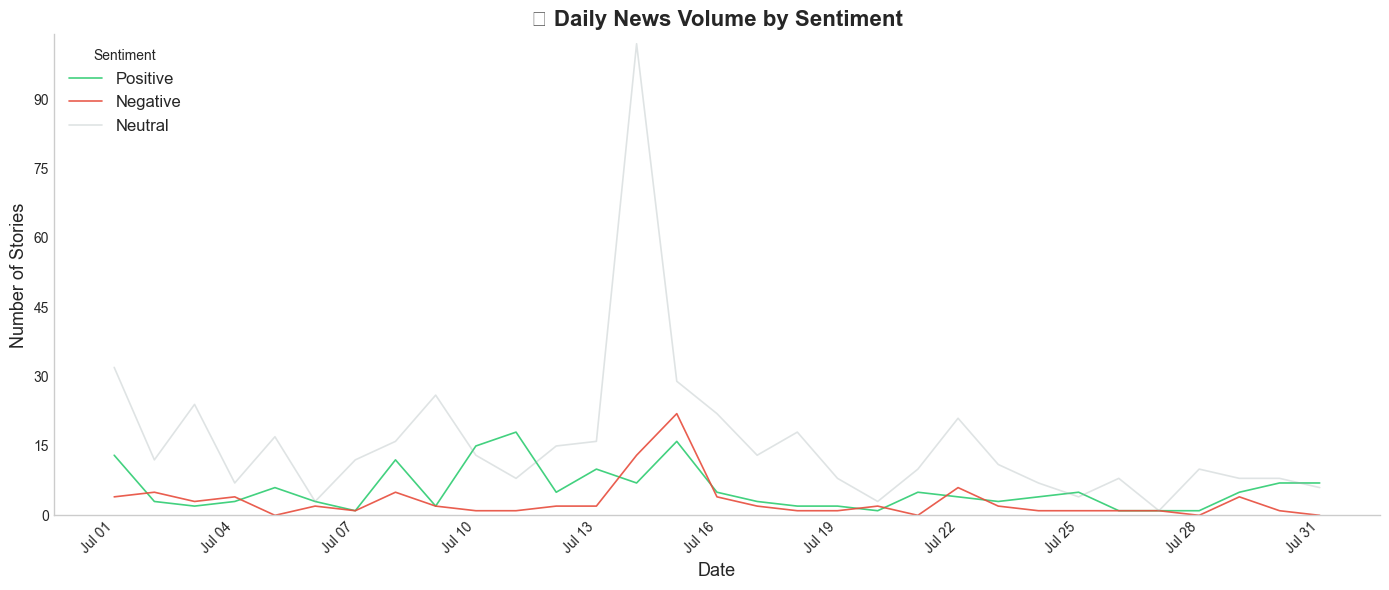

In [74]:
# --- Group and Pivot Daily Sentiment Counts ---
daily_volume_sent = (
    df
    .groupby(['Date', 'Auto_Sentiment'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
    .reset_index()
)

# Ensure all expected sentiment columns exist
for sentiment in ['Positive', 'Negative', 'Neutral']:
    if sentiment not in daily_volume_sent.columns:
        daily_volume_sent[sentiment] = 0

# --- Plot ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))

colors = {"Positive": "#2ecc71", "Negative": "#e74c3c", "Neutral": "#95a5a6"}

for sentiment in ['Positive', 'Negative', 'Neutral']:
    alpha = 0.9 if sentiment != 'Neutral' else 0.3
    ax.plot(
        daily_volume_sent['Date'],
        daily_volume_sent[sentiment],
        label=sentiment,
        color=colors[sentiment],
        linewidth=1.2,
        alpha=alpha
    )

# --- Aesthetics ---
ax.set_title("📈 Daily News Volume by Sentiment", fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=13)
ax.set_ylabel("Number of Stories", fontsize=13)

# X-axis → tick every 3 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right', fontsize=10)

# Y-axis → clean integer ticks
y_max = int(daily_volume_sent[['Positive', 'Negative', 'Neutral']].to_numpy().max())
ax.set_ylim(0, y_max + 2)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))

# Clean borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Legend
ax.legend(title="Sentiment", loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig("results/daily_sentiment_trend.png", dpi=300, bbox_inches='tight')
plt.show()


Daily Trendline (grouped every 3 days)

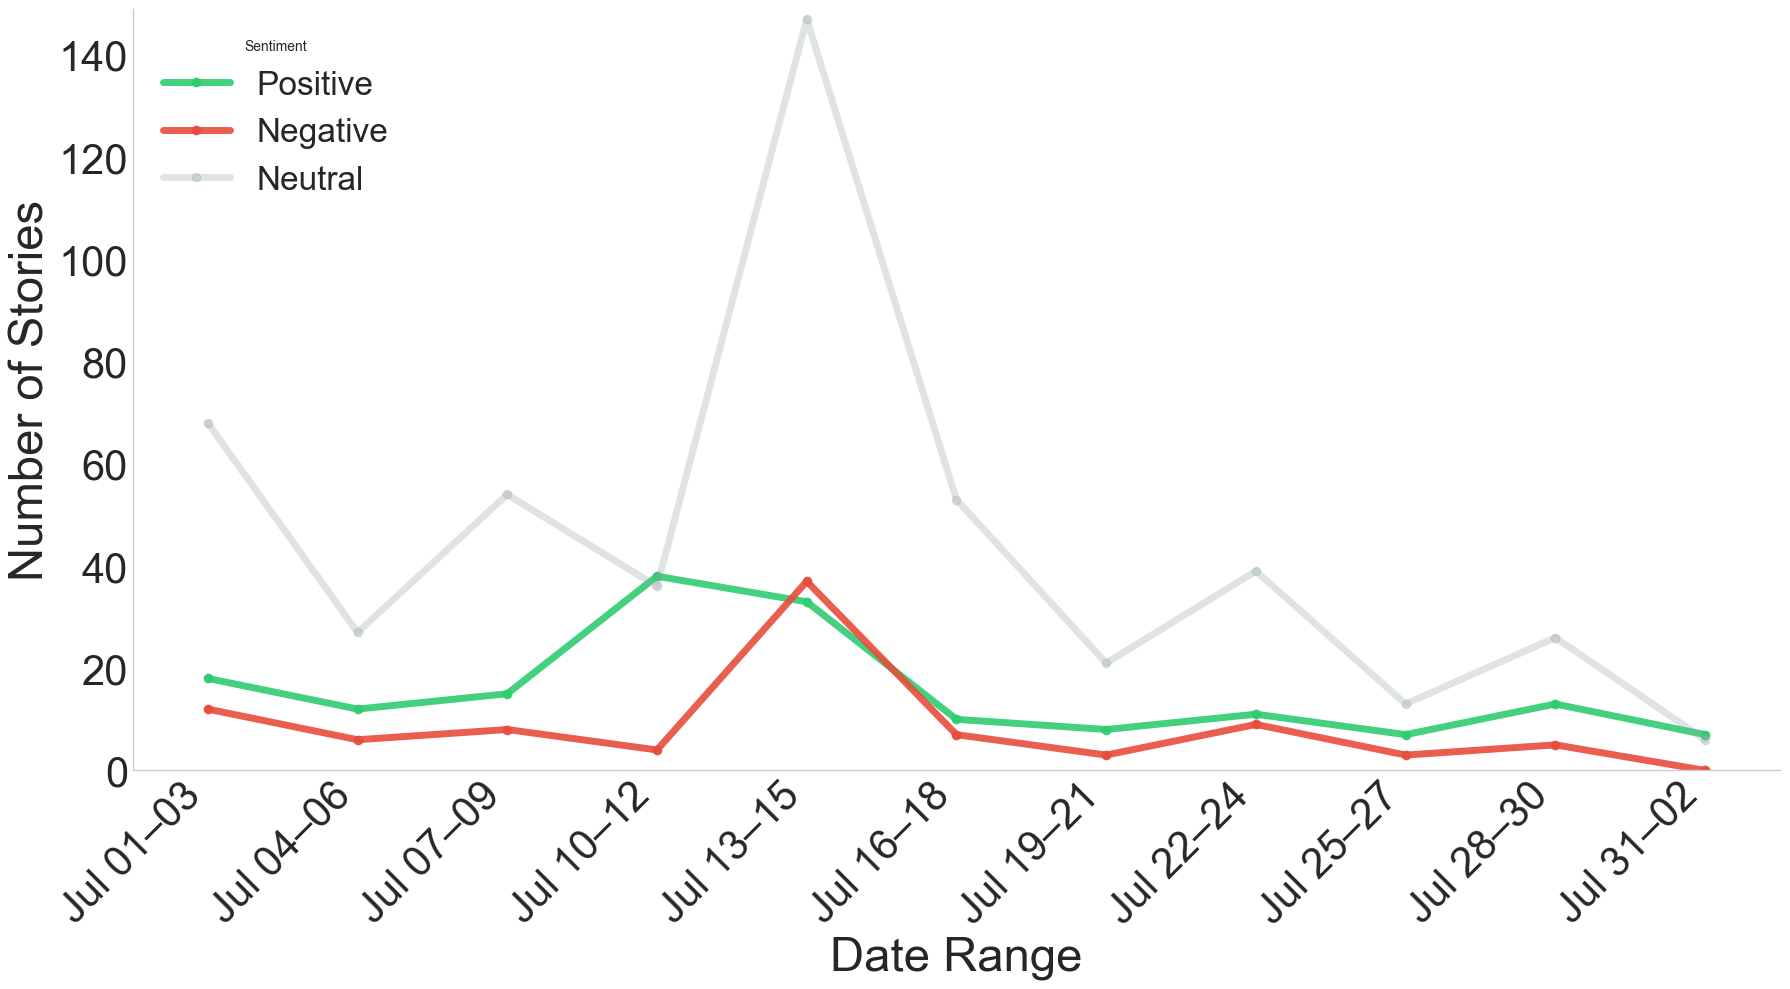

In [75]:
# --- Daily sentiment counts ---
daily_volume_sent = (
    df.groupby(['Date', 'Auto_Sentiment'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Ensure all sentiment columns exist in correct order
for s in ['Positive', 'Negative', 'Neutral']:
    if s not in daily_volume_sent.columns:
        daily_volume_sent[s] = 0
daily_volume_sent = daily_volume_sent[['Positive', 'Negative', 'Neutral']]

# --- 3-day binning ---
start = daily_volume_sent.index.min()
bin_id = ((daily_volume_sent.index - start).days // 3)
three_day_volume_sent = daily_volume_sent.groupby(bin_id).sum()

# Make index = bin start date
three_day_volume_sent.index = [
    start + pd.Timedelta(days=int(b) * 3) for b in three_day_volume_sent.index
]
three_day_volume_sent.index.name = 'Date'

# Create range labels like "Jul 13–15"
labels = []
for d in three_day_volume_sent.index:
    d_end = d + pd.Timedelta(days=2)
    label = f"{d.strftime('%b %d')}–{d_end.strftime('%d')}"
    labels.append(label)

plot_df = three_day_volume_sent.reset_index()
plot_df['Range'] = labels

# --- Plot ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(18, 10))

colors = {"Positive": "#2ecc71", "Negative": "#e74c3c", "Neutral": "#95a5a6"}
for sentiment in ['Positive', 'Negative', 'Neutral']:
    alpha = 0.9 if sentiment != 'Neutral' else 0.3
    ax.plot(
        plot_df['Range'],
        plot_df[sentiment],
        label=sentiment,
        color=colors[sentiment],
        linewidth=5,
        alpha=alpha,
        marker='o'
    )

ax.set_xlabel("Date Range", fontsize=34)
ax.set_ylabel("Number of Stories", fontsize=34)

plt.xticks(rotation=45, ha='right', fontsize=30)
plt.yticks(fontsize=30)

y_max = int(three_day_volume_sent.to_numpy().max())
ax.set_ylim(0, y_max + 2)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.legend(title="Sentiment", loc='upper left', frameon=False, fontsize=24)

plt.tight_layout()
plt.savefig("results/three_day_sentiment_trend.png", dpi=600, bbox_inches='tight')
plt.show()


In [76]:
# Define list of social media platforms (extend as needed)
social_media_platforms = ["twitter", "facebook", "instagram", "youtube", "reddit", "tiktok", "wechat", "weibo", "linkedin"]

# Function to classify source
def classify_source(source):
    if pd.isna(source):
        return "Unknown"
    source_lower = str(source).lower()
    for platform in social_media_platforms:
        if platform in source_lower:
            return "Social"
    return "Traditional"

# Create new column
df["Source_Type"] = df["Source_Normalized"].apply(classify_source)

# Quick check
print(df["Source_Type"].value_counts())


Source_Type
Traditional    505
Social         251
Name: count, dtype: int64


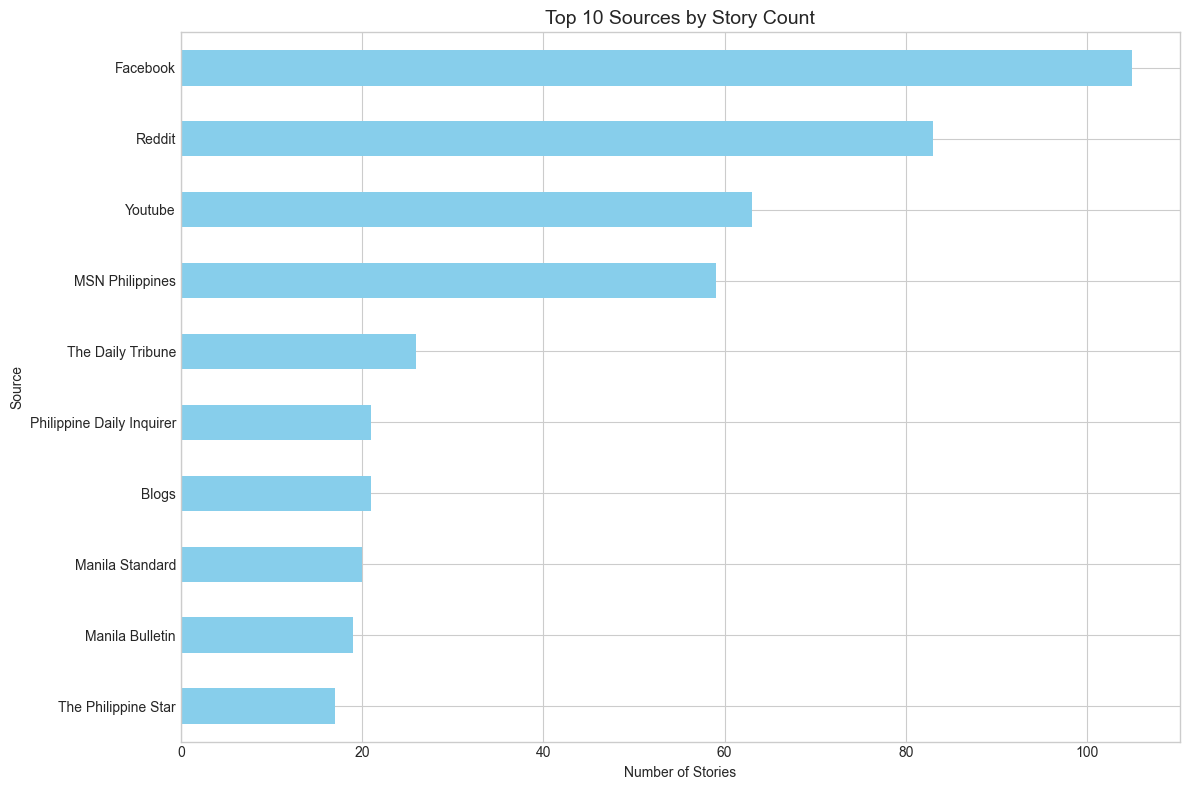

In [77]:
# Source analysis
top_sources = df['Source_Normalized'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 8))
top_sources.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Sources by Story Count', fontsize=14)
plt.xlabel('Number of Stories')
plt.ylabel('Source')
plt.tight_layout()
fig.savefig("results/top_sources.png", bbox_inches="tight")
plt.show()

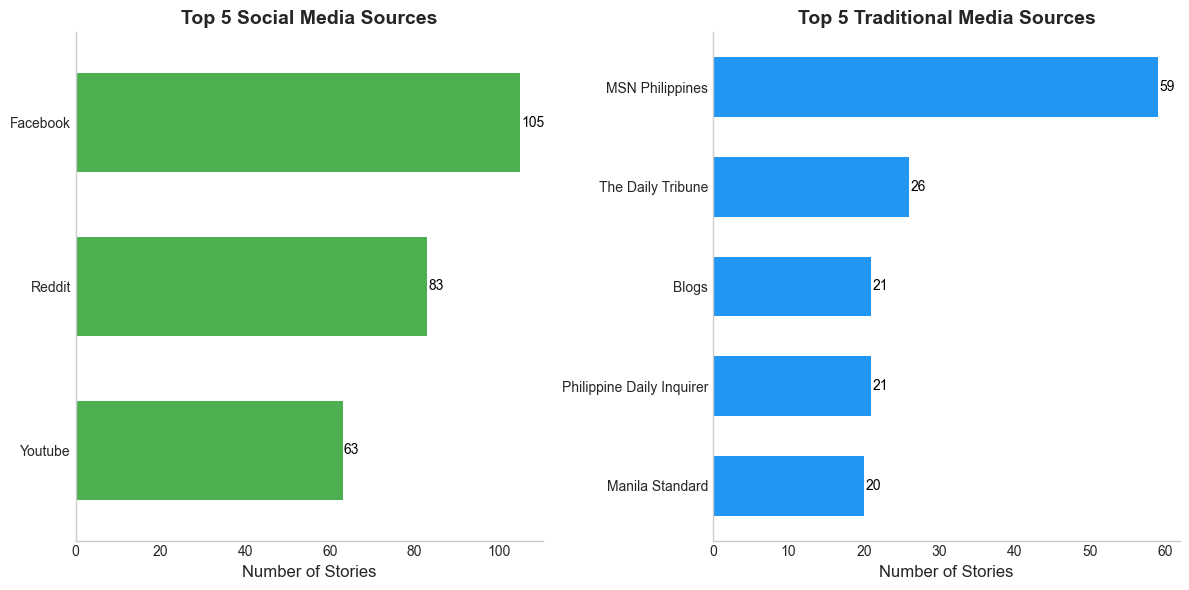

In [78]:
# Get top 5 social media sources
top_social = (
    df[df["Source_Type"] == "Social"]["Source_Normalized"]
    .value_counts()
    .head(5)
)

# Get top 5 traditional media sources
top_traditional = (
    df[df["Source_Type"] == "Traditional"]["Source_Normalized"]
    .value_counts()
    .head(5)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot Social Media (thinner bars)
top_social_sorted = top_social.sort_values()
top_social_sorted.plot(
    kind="barh",
    color="#4CAF50",
    ax=axes[0],
    width=0.6  # thinner bars (default is 0.8)
)
axes[0].set_title("Top 5 Social Media Sources", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Number of Stories", fontsize=12)
axes[0].set_ylabel("")  # remove y label
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Remove gridlines
axes[0].grid(False)

# Add data labels on bars
for i, v in enumerate(top_social_sorted):
    axes[0].text(v + 0.2, i, str(v), color='black', va='center', fontsize=10)

# Plot Traditional Media
top_traditional_sorted = top_traditional.sort_values()
top_traditional_sorted.plot(
    kind="barh",
    color="#2196F3",
    ax=axes[1],
    width=0.6
)
axes[1].set_title("Top 5 Traditional Media Sources", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Number of Stories", fontsize=12)
axes[1].set_ylabel("")  # remove y label
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(False)

# Add data labels on bars
for i, v in enumerate(top_traditional_sorted):
    axes[1].text(v + 0.2, i, str(v), color='black', va='center', fontsize=10)

# Reduce space between plots
plt.subplots_adjust(wspace=0.25)  # decrease this number to bring plots closer

plt.tight_layout()
fig.savefig("results/top5_social_traditional_sources.png", bbox_inches="tight")
plt.show()



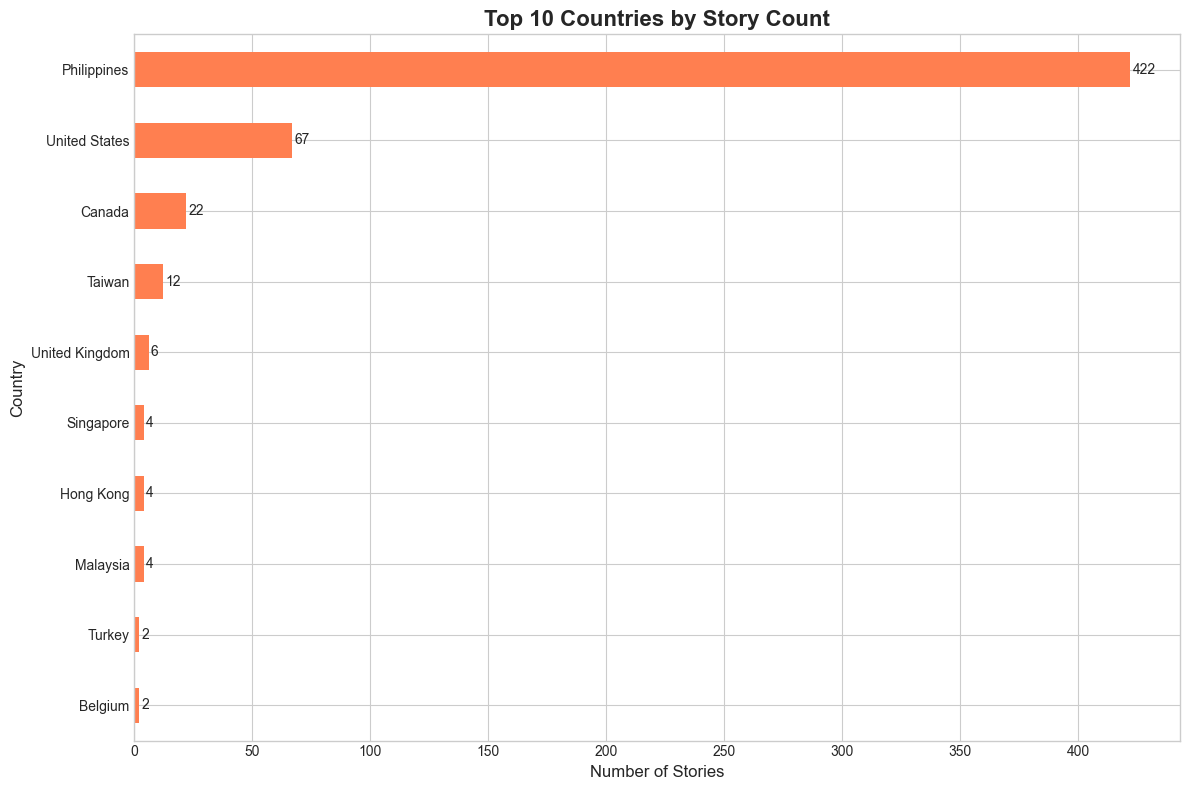

In [79]:
import matplotlib.pyplot as plt

# Exclude 'Unknown' before taking the top 10
filtered_df = df[df['Nation'].notna() & (df['Nation'].str.lower() != 'unknown')]

# Get top 10 countries
top_countries = filtered_df['Nation'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 8))
bars = top_countries.sort_values().plot(
    kind='barh',
    color='coral',
    edgecolor='none'  # removes borders from bars
)

# Titles and labels
plt.title('Top 10 Countries by Story Count', fontsize=16, weight='bold')
plt.xlabel('Number of Stories', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Annotate bar values
for i, v in enumerate(top_countries.sort_values()):
    plt.text(v + 1, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()



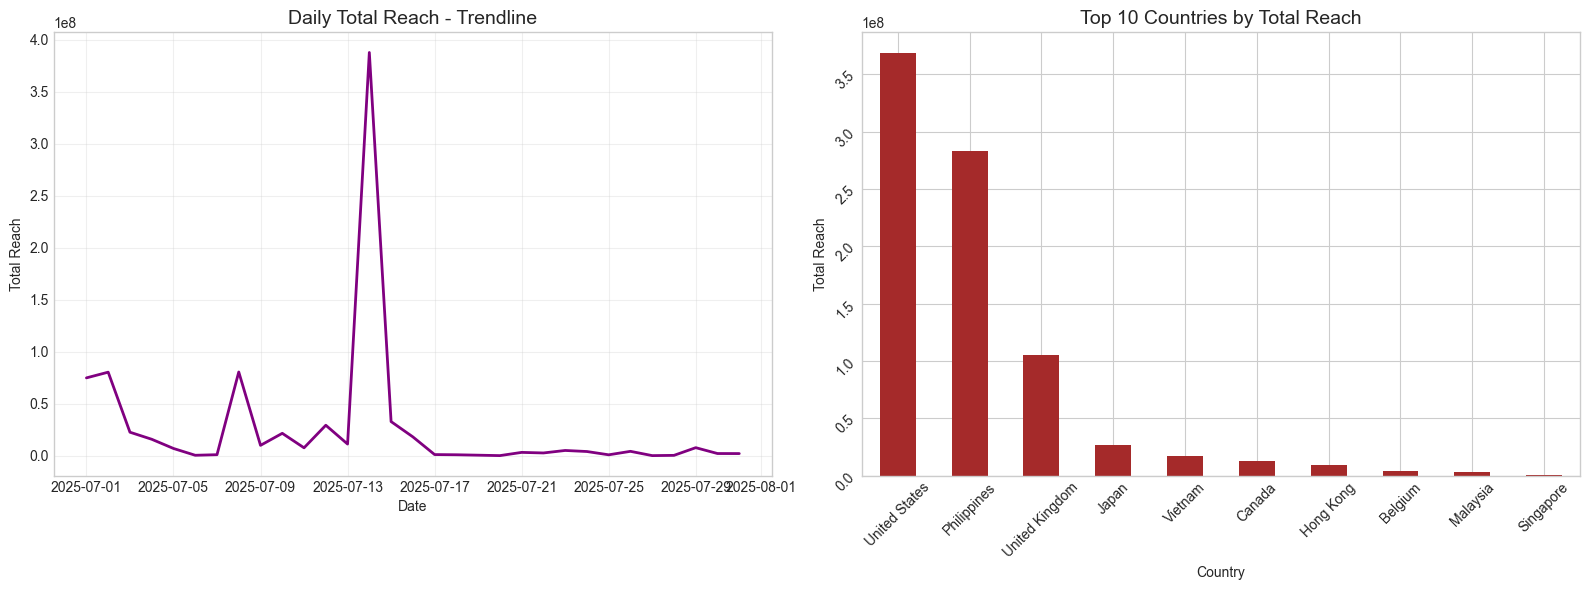

<Figure size 640x480 with 0 Axes>

In [80]:
# Engagement trends using Reach
# Calculate total reach
df['Total_Reach'] = df['Desktop Reach'].fillna(0) + df['Mobile Reach'].fillna(0)

# Daily reach
daily_reach = df.groupby('Date')['Total_Reach'].sum().reset_index()

# Country reach
country_reach = df.groupby('Nation')['Total_Reach'].sum().sort_values(ascending=False).head(10)

# Create engagement visualization (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Daily reach trendline
axes[0].plot(daily_reach['Date'], daily_reach['Total_Reach'], linewidth=2, color='purple')
axes[0].set_title('Daily Total Reach - Trendline', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Reach')
axes[0].grid(True, alpha=0.3)

# Country reach
country_reach.plot(kind='bar', ax=axes[1], color='brown')
axes[1].set_title('Top 10 Countries by Total Reach', fontsize=14)
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Total Reach')
axes[1].tick_params(rotation=45)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

## Challenge 4: Topic Identification (Content Analysis)

Time Allocation: 45 minutes - 1 hour

In [81]:
print("Analyzing Keywords...")

# ✅ Define a mapping for known synonyms / abbreviations
keyword_map = {
    "dnd": "department of national defense",
    "dept. of national defense": "department of national defense",
    "department of ⁣national defense": "department of national defense",  # hidden char version
    # add more mappings as needed
}

def process_keywords(text):
    if pd.isna(text):
        return None
    if ',' in str(text):
        keyword_list = str(text).split(',')
    elif ';' in str(text):
        keyword_list = str(text).split(';')
    else:
        keyword_list = [str(text)]
    
    cleaned = []
    for k in keyword_list:
        # normalise whitespace + hidden chars
        k = k.strip().lower()
        k = re.sub(r'\s+', ' ', k)  
        k = k.replace('\u200b', '').replace('\u200c', '').replace('\u200d', '').replace('\xa0', ' ')
        # map synonyms to canonical form
        if k in keyword_map:
            k = keyword_map[k]
        if k:
            cleaned.append(k)
    return cleaned

# ✅ Apply transformation once — this column will be used everywhere downstream
df['Keywords_Lower'] = df['Keywords'].apply(process_keywords)

# ✅ Flatten all keywords (already cleaned + normalised)
all_keywords = [kw for sublist in df['Keywords_Lower'].dropna() for kw in sublist]

# ✅ Count occurrences
keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(10)

print(f"Total unique keywords: {len(keyword_counts)}")
print(f"Total keyword occurrences: {len(all_keywords)}")
print("\nTop 10 Keywords:")
for keyword, count in top_keywords:
    print(f"{keyword}: {count}")


Analyzing Keywords...
Total unique keywords: 2
Total keyword occurrences: 1816

Top 10 Keywords:
department of national defense: 1046
philippines: 770


In [82]:
# Process Key Phrases column
print("\nAnalyzing Key Phrases...")

# Extract all key phrases
all_phrases = []
for phrases in df['Key Phrases'].dropna():
    # Try different delimiters
    if ',' in str(phrases):
        phrase_list = str(phrases).split(',')
    elif ';' in str(phrases):
        phrase_list = str(phrases).split(';')
    else:
        phrase_list = [str(phrases)]
    
    # Clean and add phrases
    all_phrases.extend([p.strip() for p in phrase_list if p.strip()])

# Count phrase occurrences
phrase_counts = Counter(all_phrases)
top_phrases = phrase_counts.most_common(10)

print(f"Total unique phrases: {len(phrase_counts)}")
print(f"Total phrase occurrences: {len(all_phrases)}")
print("\nTop 10 Key Phrases:")
for phrase, count in top_phrases:
    print(f"{phrase}: {count}")


Analyzing Key Phrases...
Total unique phrases: 2484
Total phrase occurrences: 5973

Top 10 Key Phrases:
country: 78
countries: 76
foreign citizenship: 66
defense secretary: 63
dual citizenship: 62
appointment: 55
maltese passport: 48
golden passport” program: 48
defense chief: 45
defense department: 43


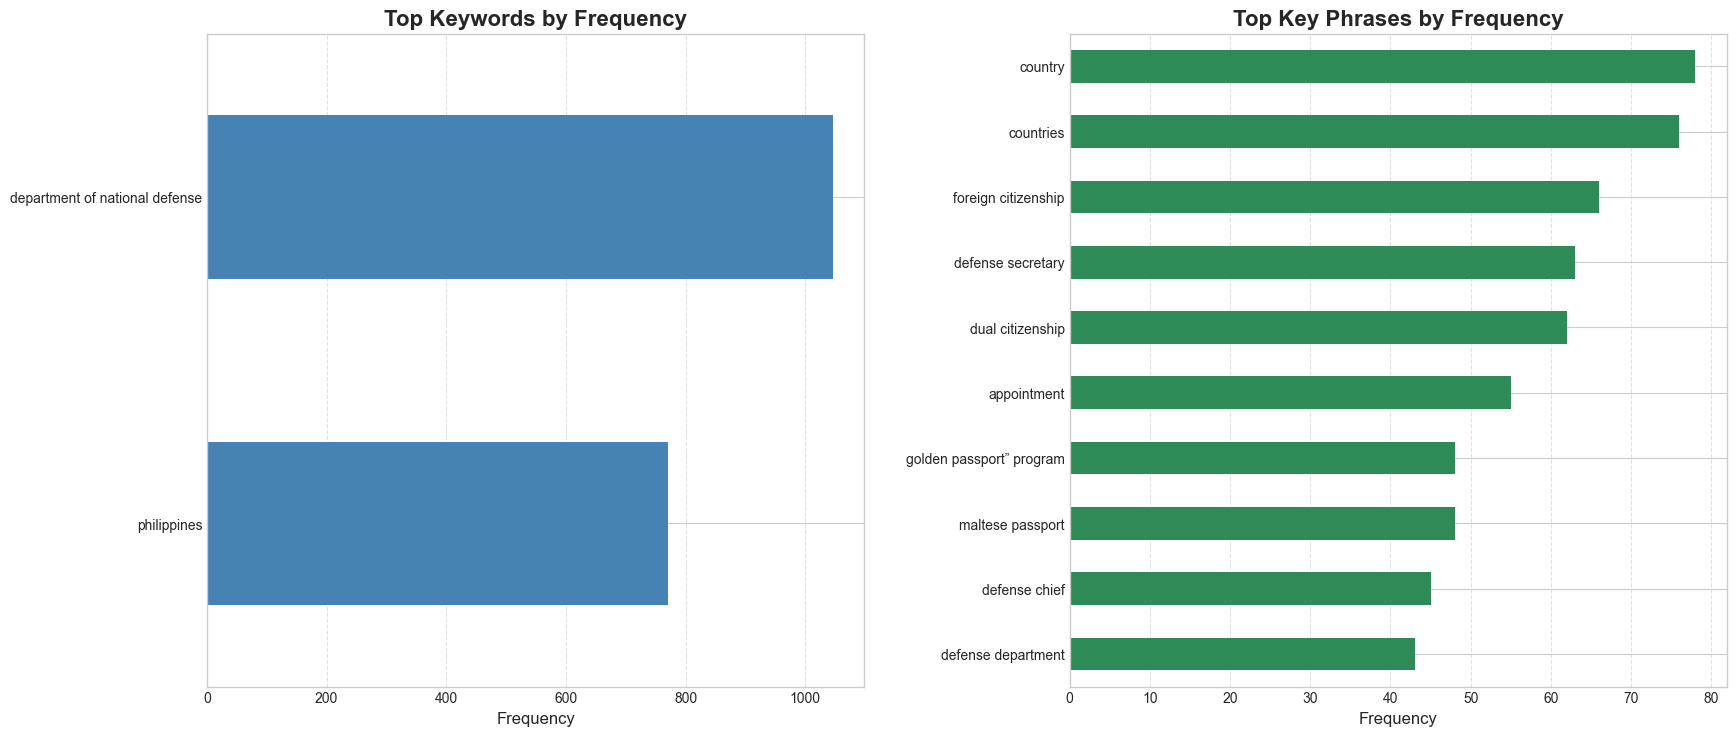

In [83]:
# Create keyword frequency charts - horizontal bars
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Keywords horizontal bar chart
keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'Count'])
keywords_df.sort_values('Count').plot(
    x='Keyword', y='Count', kind='barh', ax=axes[0],
    color='steelblue', legend=False
)
axes[0].set_title('Top Keywords by Frequency', fontsize=16, weight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Key phrases horizontal bar chart
phrases_df = pd.DataFrame(top_phrases, columns=['Phrase', 'Count'])
phrases_df.sort_values('Count').plot(
    x='Phrase', y='Count', kind='barh', ax=axes[1],
    color='seagreen', legend=False
)
axes[1].set_title('Top Key Phrases by Frequency', fontsize=16, weight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

# Improve spacing & aesthetics
plt.tight_layout(pad=3)
plt.show()


In [84]:
# Analyze which sources use which keywords most
print("\nKeyword Usage by Source:")

df['Keywords_Lower'] = df['Keywords'].apply(process_keywords)

#Group keywords by source
source_keywords = {}
for idx, row in df.iterrows():
    source = row['Source_Normalized']
    keywords_list = row['Keywords_Lower']

    if pd.notna(source) and isinstance(keywords_list, list):
        source_keywords.setdefault(source, []).extend(keywords_list)

#Print results for top 5 sources
top_5_sources = df['Source_Normalized'].value_counts().head(5).index

print("\nTop Keywords by Top 5 Sources:")
for source in top_5_sources:
    if source in source_keywords:
        source_keyword_counts = Counter(source_keywords[source])
        top_3_keywords = source_keyword_counts.most_common(3)
        print(f"\n{source}:")
        for keyword, count in top_3_keywords:
            print(f"  - {keyword}: {count}")


Keyword Usage by Source:

Top Keywords by Top 5 Sources:

Facebook:
  - department of national defense: 123
  - philippines: 109

Reddit:
  - department of national defense: 89
  - philippines: 83

Youtube:
  - department of national defense: 88
  - philippines: 70

MSN Philippines:
  - department of national defense: 84
  - philippines: 59

The Daily Tribune:
  - department of national defense: 40
  - philippines: 26


## Challenge 5: Word Cloud Visualization (Visual Analysis)

Time Allocation: 45 minutes - 1 hour

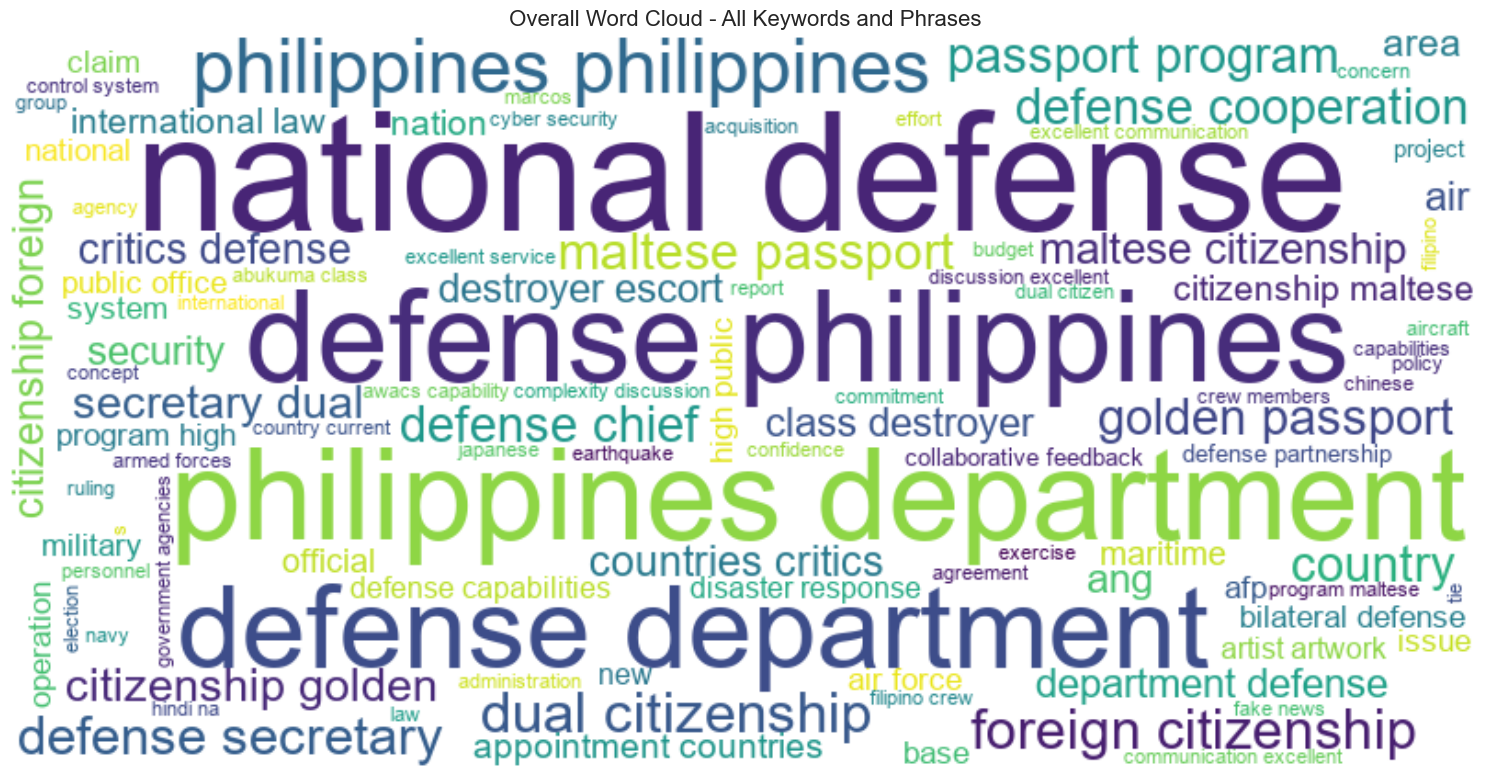

In [85]:
# Prepare text for word clouds
# Combine keywords and key phrases
all_text_keywords = ' '.join(all_keywords)
all_text_phrases = ' '.join(all_phrases)
combined_text = all_text_keywords + ' ' + all_text_phrases

# Create overall word cloud
plt.figure(figsize=(15, 8))
wordcloud = WordCloud(font_path = 'arial', width=800, height=400, background_color='white', 
                     colormap='viridis', max_words=100).generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud - All Keywords and Phrases', fontsize=16)
plt.tight_layout()

#save image to results folder
plt.savefig("results/wordcloud.png", bbox_inches="tight", dpi=150)

plt.show()

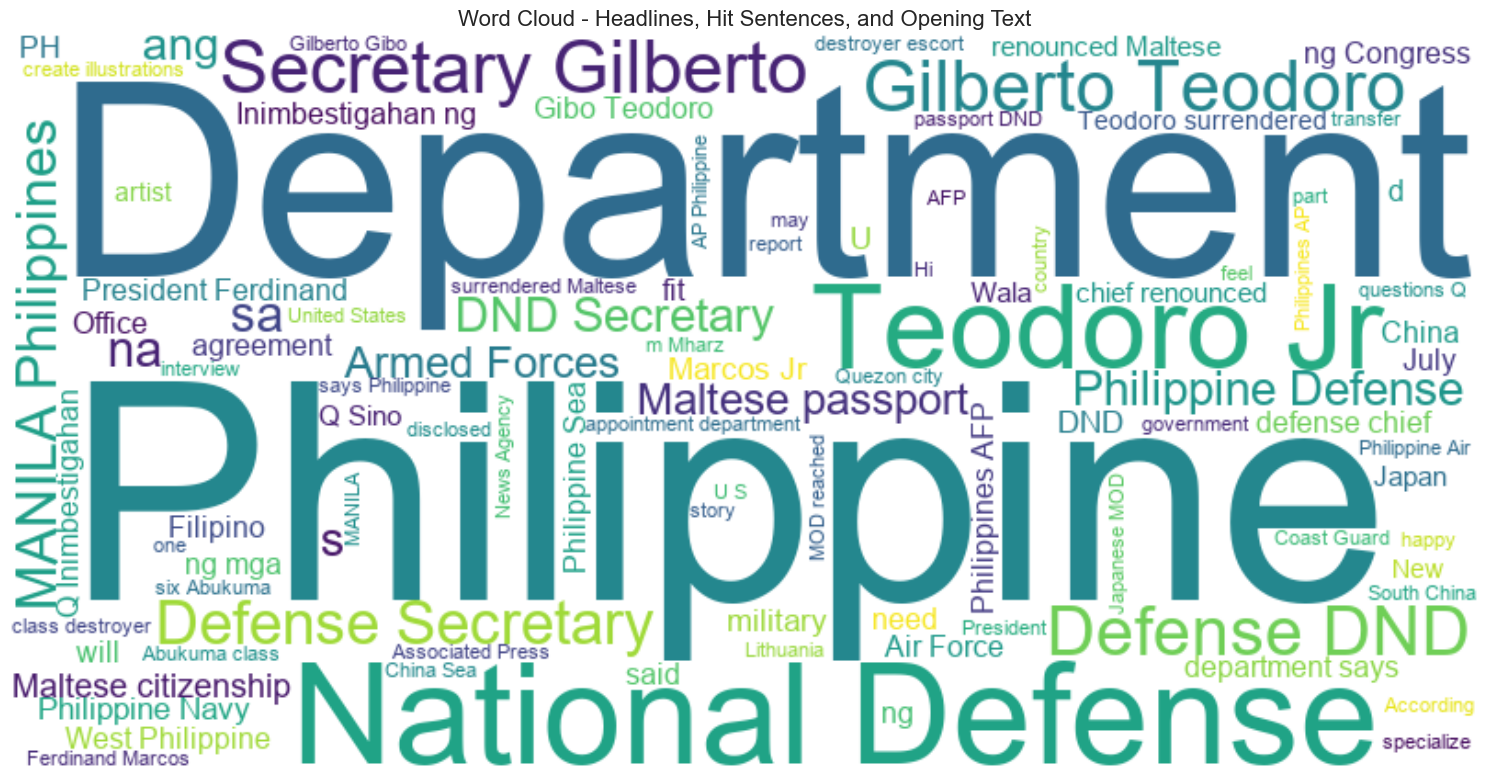

In [86]:
# Prepare text for word clouds - Headlines, Hit Sentence, Opening Text
all_text_headlines = ' '.join(df['Headline'].dropna().astype(str))
all_text_hits = ' '.join(df['Hit Sentence'].dropna().astype(str))
all_text_opening = ' '.join(df['Opening Text'].dropna().astype(str))

combined_text = all_text_headlines + ' ' + all_text_hits + ' ' + all_text_opening

# Create word cloud
plt.figure(figsize=(15, 8))
wordcloud = WordCloud(
    font_path='arial', 
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=100
).generate(combined_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Headlines, Hit Sentences, and Opening Text', fontsize=16)
plt.tight_layout()

# Save image to results folder
plt.savefig("results/wordcloud_headline_hit_opening.png", bbox_inches="tight", dpi=150)

plt.show()


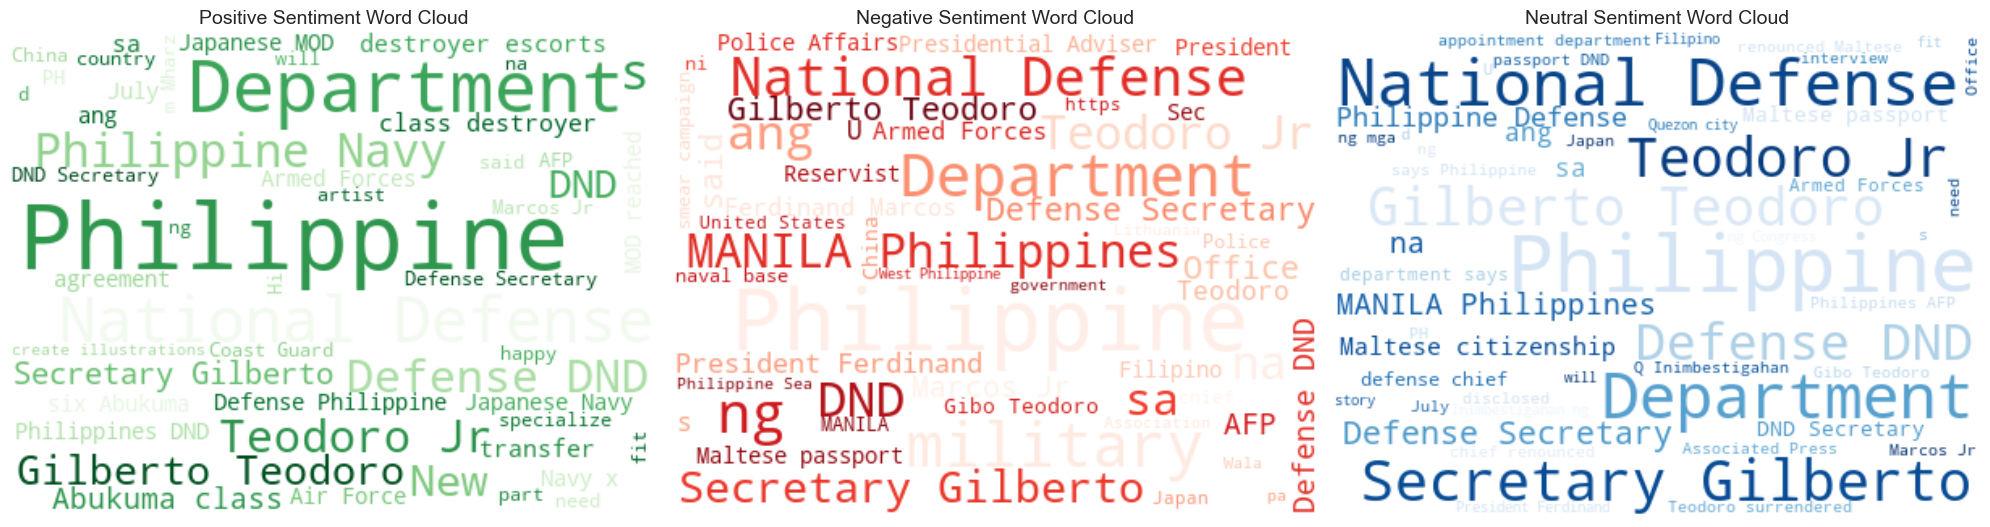

In [87]:
# Create sentiment-specific word clouds (based on Headline, Hit Sentence, Opening Text)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['Greens', 'Reds', 'Blues']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    # Filter dataframe for this sentiment
    sentiment_df = df[df['Auto_Sentiment'] == sentiment]
    
    # Combine text from headline, hit sentence, and opening text
    all_text = (
        sentiment_df['Headline'].dropna().astype(str).tolist() +
        sentiment_df['Hit Sentence'].dropna().astype(str).tolist() +
        sentiment_df['Opening Text'].dropna().astype(str).tolist()
    )
    
    if all_text:
        sentiment_text = " ".join(all_text)
        wordcloud = WordCloud(
            width=400, 
            height=300, 
            background_color='white',
            colormap=color, 
            max_words=50
        ).generate(sentiment_text)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment Word Cloud', fontsize=14)
    else:
        axes[idx].text(
            0.5, 0.5, 'No text available',
            horizontalalignment='center',
            verticalalignment='center'
        )
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment Word Cloud', fontsize=14)

plt.tight_layout()
plt.show()


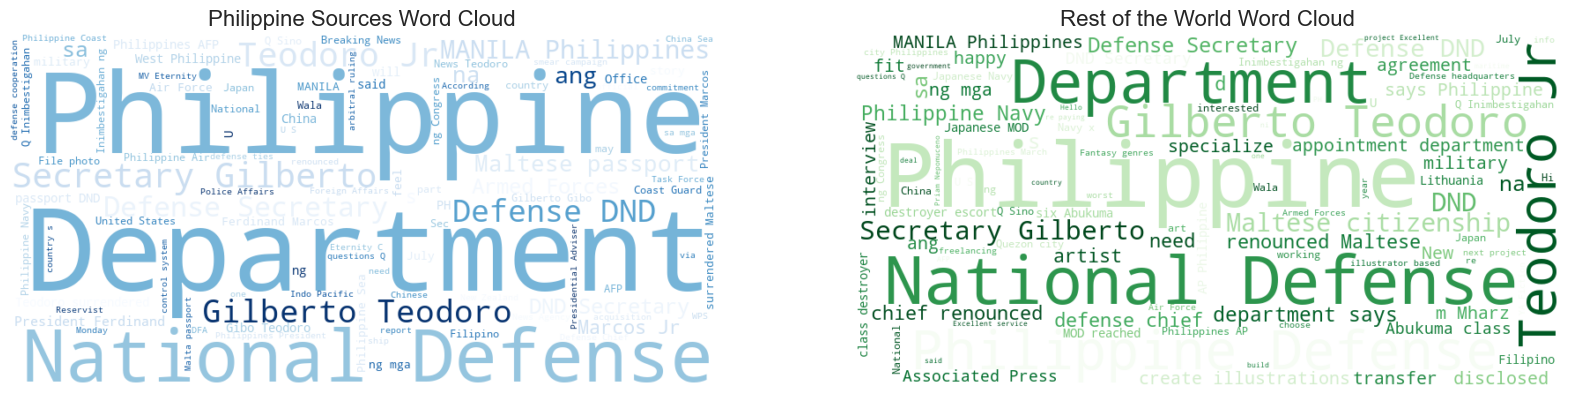

In [88]:
# Create word clouds for Philippine sources vs Rest of World
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

groups = {
    "Philippine Sources": df[df['Nation'].str.lower().str.contains("philippine", na=False)],
    "Rest of the World": df[~df['Nation'].str.lower().str.contains("philippine", na=False)]
}

colors = ['Blues', 'Greens']

for idx, (group_name, group_df) in enumerate(groups.items()):
    # Combine text from headline, hit sentence, and opening text
    all_text = (
        group_df['Headline'].dropna().astype(str).tolist() +
        group_df['Hit Sentence'].dropna().astype(str).tolist() +
        group_df['Opening Text'].dropna().astype(str).tolist()
    )
    
    if all_text:
        combined_text = " ".join(all_text)
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap=colors[idx],
            max_words=100
        ).generate(combined_text)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{group_name} Word Cloud', fontsize=16)
    else:
        a


## Challenge 6: Summary Insights (Simple Business Analysis)

Time Allocation: 45 minutes - 1 hour

In [89]:
# Question 1: Top 5 sources by number of stories
top_5_sources_list = df['Source_Normalized'].value_counts().head(5)
print("1. Top 5 Sources by Number of Stories:")
print("="*50)
for i, (source, count) in enumerate(top_5_sources_list.items(), 1):
    print(f"{i}. {source}: {count} stories")
print()

1. Top 5 Sources by Number of Stories:
1. Facebook: 105 stories
2. Reddit: 83 stories
3. Youtube: 63 stories
4. MSN Philippines: 59 stories
5. The Daily Tribune: 26 stories



In [90]:
# Question 2: Country with most positive sentiment stories
positive_by_country = (
    df[df['Auto_Sentiment'] == 'Positive']['Nation']
    .dropna()
    .loc[lambda x: ~x.str.contains("unknown", case=False, na=False)]
    .value_counts()
)

print("2. Country with Most Positive Sentiment Stories:")
print("="*50)

if not positive_by_country.empty:
    top_positive_country = positive_by_country.index[0]
    top_positive_count = positive_by_country.iloc[0]
    print(f"The country with the most positive stories is the {top_positive_country}: {top_positive_count} positive stories")
    print("\nTop 5 countries by positive stories:")
    for country, count in positive_by_country.head(5).items():
        print(f"  - {country}: {count}")
else:
    print("No valid positive sentiment stories found (excluding 'unknown countries').")

print()


2. Country with Most Positive Sentiment Stories:
The country with the most positive stories is the Philippines: 86 positive stories

Top 5 countries by positive stories:
  - Philippines: 86
  - United States: 9
  - Canada: 3
  - Hong Kong: 2
  - Singapore: 1



In [91]:
print("3. Most Common Keyword/Topic:")
print("="*50)

all_keywords_lower = [kw for sublist in df['Keywords_Lower'].dropna() if isinstance(sublist, list) for kw in sublist]

# Count frequencies
keyword_counts = Counter(all_keywords_lower)
top_keywords = keyword_counts.most_common()

if top_keywords:
    most_common_keyword = top_keywords[0]
    print(f"Most common keyword: '{most_common_keyword[0]}' (appears {most_common_keyword[1]} times)")
    print("\nTop 5 keywords:")
    for keyword, count in top_keywords[:5]:
        print(f"  - {keyword}: {count}")
else:
    print("No keywords found.")
print()


3. Most Common Keyword/Topic:
Most common keyword: 'department of national defense' (appears 1046 times)

Top 5 keywords:
  - department of national defense: 1046
  - philippines: 770



In [92]:
# Question 4: Month with most stories
month_story_count = df.groupby(['Year', 'MonthName', 'Month']).size().reset_index(name='Count')
month_story_count = month_story_count.sort_values('Count', ascending=False)

print("4. Month with Most Stories:")
print("="*50)
if not month_story_count.empty:
    top_month = month_story_count.iloc[0]
    print(f"{top_month['MonthName']} {int(top_month['Year'])}: {top_month['Count']} stories")
    print("\nTop 5 months by story count:")
    for _, row in month_story_count.head(5).iterrows():
        print(f"  - {row['MonthName']} {int(row['Year'])}: {row['Count']} stories")
print()

4. Month with Most Stories:
July 2025: 756 stories

Top 5 months by story count:
  - July 2025: 756 stories



In [93]:
# Question 5: Source with highest average reach
# Calculate average total reach by source
avg_reach_by_source = df.groupby('Source_Normalized')['Total_Reach'].agg(['mean', 'count'])
avg_reach_by_source = avg_reach_by_source[avg_reach_by_source['count'] >= 5]  # Filter sources with at least 5 stories
avg_reach_by_source = avg_reach_by_source.sort_values('mean', ascending=False)

print("5. Source with Highest Average Reach:")
print("="*50)
if not avg_reach_by_source.empty:
    top_reach_source = avg_reach_by_source.index[0]
    top_reach_value = avg_reach_by_source.iloc[0]['mean']
    top_reach_count = avg_reach_by_source.iloc[0]['count']
    print(f"{top_reach_source}: {top_reach_value:,.0f} average reach (from {top_reach_count} stories)")
    print("\nTop 5 sources by average reach (min 5 stories):")
    for source in avg_reach_by_source.head(5).index:
        avg = avg_reach_by_source.loc[source, 'mean']
        count = avg_reach_by_source.loc[source, 'count']
        print(f"  - {source}: {avg:,.0f} (from {count} stories)")
print()

5. Source with Highest Average Reach:
Yahoo! News: 25,125,671 average reach (from 8.0 stories)

Top 5 sources by average reach (min 5 stories):
  - Yahoo! News: 25,125,671 (from 8 stories)
  - GMA News: 4,673,874 (from 8 stories)
  - ABS-CBN News: 4,020,966 (from 10 stories)
  - Philippine Daily Inquirer: 3,668,877 (from 21 stories)
  - The Philippine Star: 3,012,411 (from 17 stories)



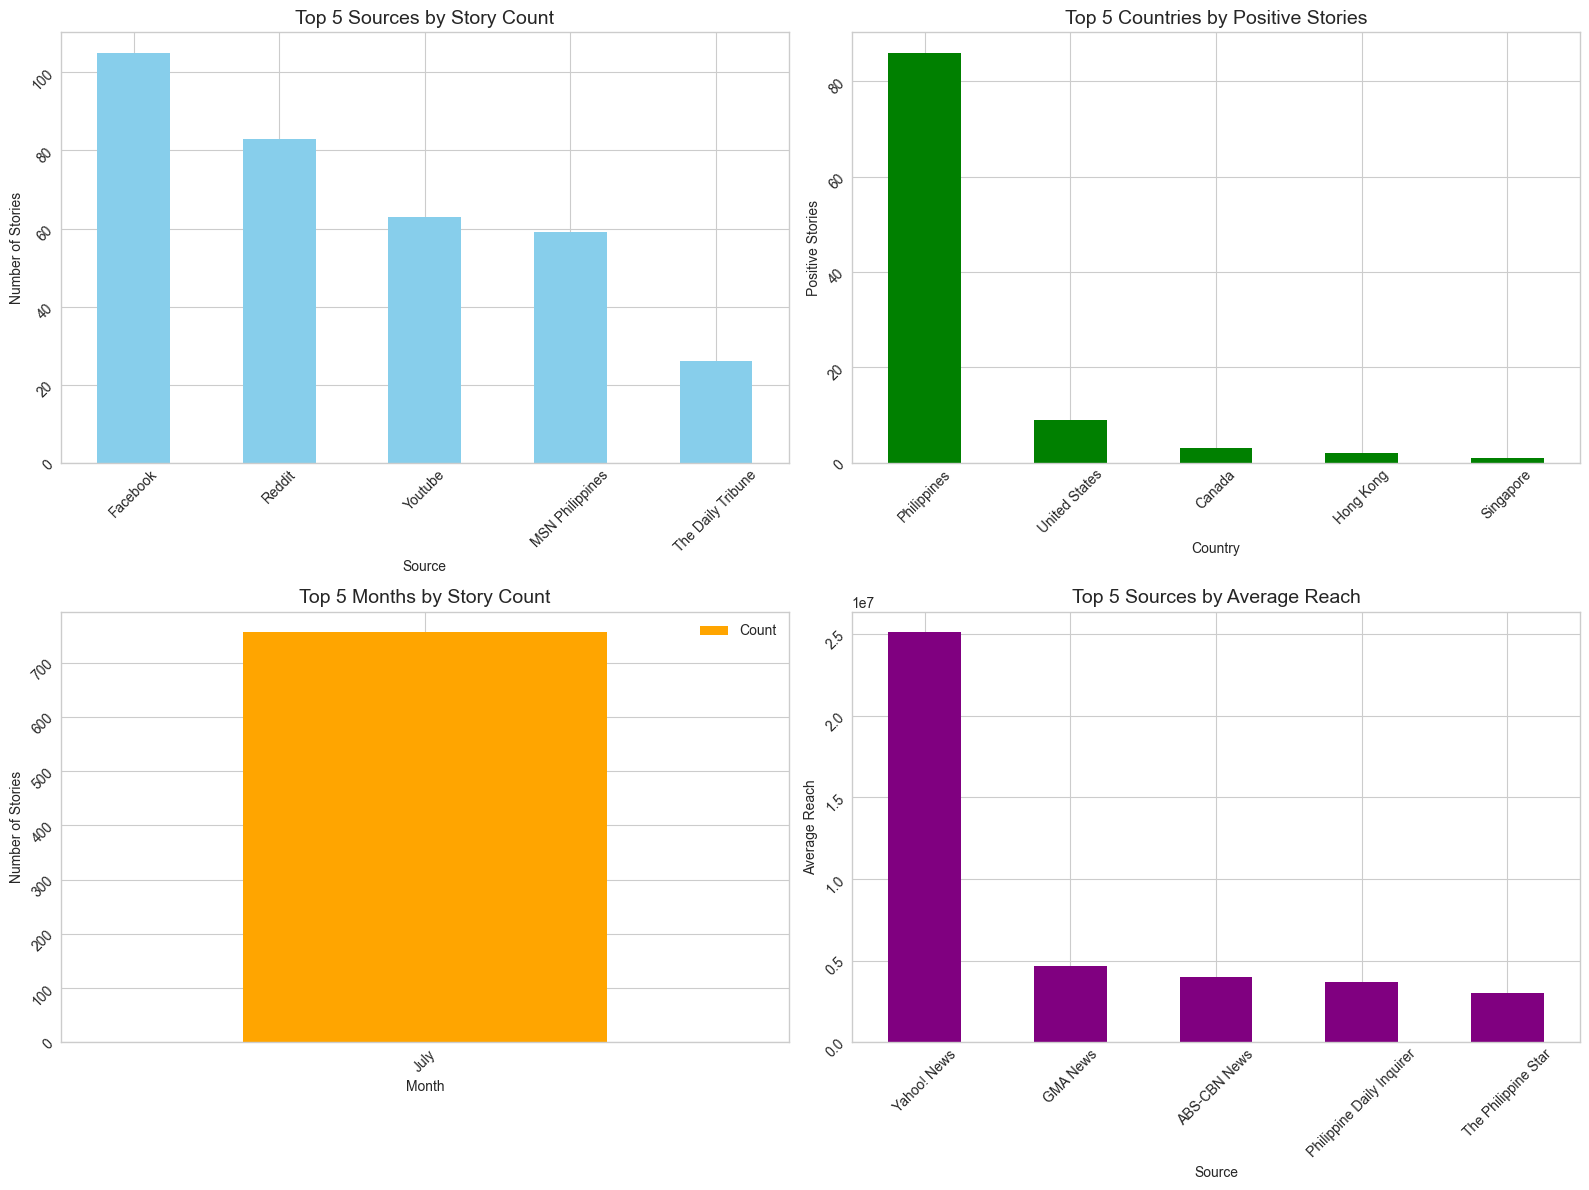

In [94]:
# Create summary visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top sources chart
top_5_sources_list.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Top 5 Sources by Story Count', fontsize=14)
axes[0, 0].set_xlabel('Source')
axes[0, 0].set_ylabel('Number of Stories')
axes[0, 0].tick_params(rotation=45)

# Positive sentiment by country
positive_by_country.head(5).plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Top 5 Countries by Positive Stories', fontsize=14)
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Positive Stories')
axes[0, 1].tick_params(rotation=45)

# Monthly story distribution
month_story_count.head(5).plot(x='MonthName', y='Count', kind='bar', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Top 5 Months by Story Count', fontsize=14)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Stories')
axes[1, 0].tick_params(rotation=45)

# Average reach by source
avg_reach_by_source.head(5)['mean'].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Top 5 Sources by Average Reach', fontsize=14)
axes[1, 1].set_xlabel('Source')
axes[1, 1].set_ylabel('Average Reach')
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
plt.show()

## Challenge 7: Export Results (Final Output)

Time Allocation: 30-45 minutes

In [95]:
# Prepare clean dataset for export
export_columns = ['Date', 'Headline', 'URL', 
                 'Source', 'Source_Normalized', 'Source_Type', 'Nation', 'Sentiment', 'Auto_Sentiment',
                 'Keywords', 'Key Phrases', 'Total_Reach', 'Desktop Reach', 'Mobile Reach']

clean_export_df = df[export_columns].copy()

# --- Summary statistics ---
summary_stats = pd.DataFrame({
    'Metric': ['Total Stories', 'Date Range', 'Unique Sources', 'Unique Countries', 
               'Stories with Keywords', 'Average Total Reach'],
    'Value': [
        len(df),
        f"{df['Date'].min().date()} to {df['Date'].max().date()}",
        df['Source_Normalized'].nunique(),
        df['Nation'].nunique(),
        df['Keywords'].notna().sum(),
        f"{df['Total_Reach'].mean():,.0f}"
    ]
})

# --- Source counts ---
source_counts = (
    df.groupby(['Source_Type', 'Source_Normalized'])
      .size()
      .reset_index(name='Story_Count')
      .sort_values(['Source_Type', 'Story_Count'], ascending=[True, False])
)

# --- Top 5 Social ---
top5_social = (
    source_counts[source_counts['Source_Type'] == 'Social']
    .head(5)
    .copy()
)
top5_social['Percentage'] = (top5_social['Story_Count'] / len(df) * 100).round(1)
top5_social = top5_social[['Source_Normalized', 'Story_Count', 'Percentage']]  # ensure header order

# --- Top 5 Traditional ---
top5_traditional = (
    source_counts[source_counts['Source_Type'] == 'Traditional']
    .head(5)
    .copy()
)
top5_traditional['Percentage'] = (top5_traditional['Story_Count'] / len(df) * 100).round(1)
top5_traditional = top5_traditional[['Source_Normalized', 'Story_Count', 'Percentage']]

# --- Combine if needed ---
top_sources_summary = pd.concat([top5_social, top5_traditional])

# --- Keywords ---
top_keywords_summary = pd.DataFrame(top_keywords[:10], columns=['Keyword', 'Count'])

# --- Sentiment ---
sentiment_summary = pd.DataFrame({
    'Sentiment': sentiment_counts.index,
    'Count': sentiment_counts.values,
    'Percentage': (sentiment_counts.values / sentiment_counts.sum() * 100).round(1)
})[['Sentiment', 'Count', 'Percentage']]  # enforce header order


In [96]:
from openpyxl.styles import Font, Alignment, Border, Side

with pd.ExcelWriter('media_analysis_results.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Clean Data
    clean_export_df.to_excel(writer, sheet_name='Clean_Data', index=False)
    
    # Sheet 2: Summary
    summary_stats.to_excel(writer, sheet_name='Summary', index=False, startrow=0)
    summary_ws = writer.sheets['Summary']

    # --- Top 5 Social Media Sources ---
    start_row = len(summary_stats) + 3
    summary_ws.cell(row=start_row, column=1).value = 'Top 5 Social Media Sources'
    top5_social.to_excel(writer, sheet_name='Summary', index=False, startrow=start_row + 2, header=True)

    # --- Top 5 Traditional Media Sources ---
    start_row = start_row + len(top5_social) + 5
    summary_ws.cell(row=start_row, column=1).value = 'Top 5 Traditional Media Sources'
    top5_traditional.to_excel(writer, sheet_name='Summary', index=False, startrow=start_row + 2, header=True)

    # --- Top Keywords ---
    start_row = start_row + len(top5_traditional) + 5
    summary_ws.cell(row=start_row, column=1).value = 'Top Keywords'
    top_keywords_summary.to_excel(writer, sheet_name='Summary', index=False, startrow=start_row + 2, header=True)

    # --- Sentiment Distribution ---
    start_row = start_row + len(top_keywords_summary) + 5
    summary_ws.cell(row=start_row, column=1).value = 'Sentiment Distribution'
    sentiment_summary.to_excel(writer, sheet_name='Summary', index=False, startrow=start_row + 2, header=True)

    # --- Top 3 Findings ---
    start_row = start_row + len(sentiment_summary) + 5
    summary_ws.cell(row=start_row, column=1).value = "KEY FINDINGS"
    summary_ws.cell(row=start_row, column=1).font = Font(bold=True)

    # Manually Input Findings
    findings = [
        "Finding 1: Neutral sentiment dominates coverage",
        "Finding 2: Social media sources lead in story volume",
        "Finding 3: Geographic coverage is dominated by local sources (Philippines)"
    ]

    # Style for box
    border = Border(
        left=Side(style="thin"), right=Side(style="thin"),
        top=Side(style="thin"), bottom=Side(style="thin")
    )

    for i, finding in enumerate(findings, start=1):
        row = start_row + i
        summary_ws.merge_cells(start_row=row, start_column=1, end_row=row, end_column=4)
        cell = summary_ws.cell(row=row, column=1)
        cell.value = finding
        cell.alignment = Alignment(horizontal="left", vertical="center")
        cell.border = border

print("Excel file 'media_analysis_results.xlsx' has been created successfully!")


Excel file 'media_analysis_results.xlsx' has been created successfully!


In [97]:
# Create methodology report
methodology_report = """
MEDIA ANALYSIS METHODOLOGY REPORT
=================================

1. DATA CLEANING PROCESS
------------------------
- Loaded the dataset by through chunks to handle potentially large files
- Early filtering of data and impertinent columns
- Wrote the chunks to a new single CSV for easier processing instead of keeping it in memory
- Removed duplicate records based on URL (keeping first occurrence)
- Converted date strings to datetime format and extracted date components
- Normalized source names by removing domains, standardizing case
- Filtered out records missing critical fields (Date, Headline, Source)
- Removed test data and records with invalid dates

2. SENTIMENT ANALYSIS
--------------------
- Applied TextBlob sentiment analysis to all headlines
- Classified sentiment as Positive (>0.1), Negative (<-0.1), or Neutral
- Compared automated sentiment with existing manual classifications
- Created new 'Auto_Sentiment' column for all records

3. TREND VISUALISATIONS
------------------------
- Plotted daily story volume over time
- Created sentiment trendlines (daily and 3-day binned)
- 3-day binning to smooth out daily fluctuations and capture stories that span multiple days
- Analyzed source types (social vs traditional media)
- Examined geographic distribution of stories by country
- Assessed engagement trends using total reach metrics

4. TOPIC IDENTIFICATION
-----------------------
- Processed Keywords and Key Phrases columns to extract individual topics
- Normalized keywords (lowercase, trimmed whitespace, mapped synonyms, combined dnd and department of national defense)
- Counted keyword frequencies and identified top keywords
- Analyzed keyword usage by top sources

5. WORD CLOUDS
----------------
- Generated word clouds for overall keywords, sentiment-specific, and location-specific texts

6. SUMMARY INSIGHTS
----------------
- Answered five key questions regarding top sources, countries, keywords, months, and reach

7. EXPORT RESULTS
----------------
- Created an Excel file with clean data and summary statistics
- Created a methodology_report.txt file documenting the analysis process


8. RECOMMENDATION FOR IMPROVEMENT
---------------------------------
- Many rows have 'unknown' country so analysis based on location is limited
- Additionally, source monitoring could be expanded particularly for social media platforms
- Currently, only three social media platforms are tracked.

Analysis completed on: {}
""".format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# Save methodology report
with open('methodology_report.txt', 'w') as f:
    f.write(methodology_report)

print("Methodology report saved as 'methodology_report.txt'")
print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
print("\nDeliverables created:")
print("1. media_analysis_results.xlsx - Excel file with clean data and summary")
print("2. methodology_report.txt - Brief explanation of the analysis process")
print("3. Multiple visualizations throughout the notebook")
print("\nAll 7 challenges have been completed successfully!")

Methodology report saved as 'methodology_report.txt'

ANALYSIS COMPLETE!

Deliverables created:
1. media_analysis_results.xlsx - Excel file with clean data and summary
2. methodology_report.txt - Brief explanation of the analysis process
3. Multiple visualizations throughout the notebook

All 7 challenges have been completed successfully!


## Challenge 8: Generating PDF 

Generate chart and text metrics for reporting

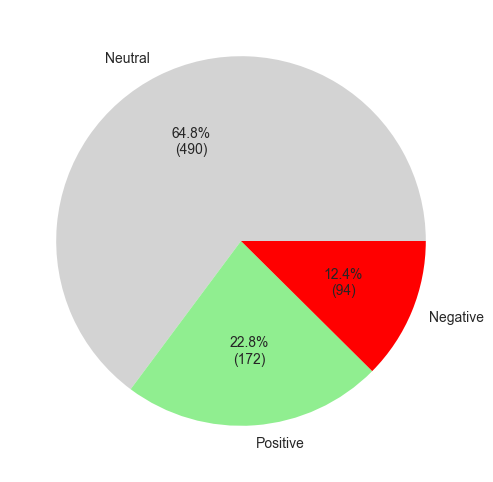

In [98]:
# Overall sentiment pie chart for reporting
sentiment_counts = df['Auto_Sentiment'].value_counts()

def autopct_format(pct, allvals):
    count = int(round(pct/100.*sum(allvals)))
    return f'{pct:.1f}%\n({count})'

fig, ax = plt.subplots(figsize=(6, 6))  # just one axis
ax.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct=lambda pct: autopct_format(pct, sentiment_counts.values),
    colors=['lightgray', 'lightgreen', 'red']
)
fig.savefig("results/sentiment.png", bbox_inches="tight")
plt.show()

In [99]:
import json

month_name = df["Date"].dt.month_name().mode()[0]
total_volume = df['Headline'].count()
total_reach = df['Total_Reach'].sum()
earliest_date = df['Date'].min()
latest_date = df['Date'].max()

#Ensure top 2 come from two different sources if possible
def get_top_two(df, condition):
    # Filter and sort
    subset = (
        df[condition]
        .sort_values("Total_Reach", ascending=False)
        [["Headline", "URL", "Source_Normalized"]]
    )

    # Step 1: pick distinct sources
    unique_sources = subset.drop_duplicates(subset=["Source_Normalized"]).head(2)

    if len(unique_sources) >= 2:
        return unique_sources.to_dict(orient="records")

    # Step 2: fallback — add more even if from same source
    top_two = subset.head(2)
    return top_two.to_dict(orient="records")

# Top 2 positive headlines from Local (Philippines-based) sources
top_positive_local = get_top_two(
    df,
    (df['Auto_Sentiment'].str.lower() == "positive") &
    (df['Nation'].str.lower().str.contains("philippine", na=False))
)
# Top 2 positive headlines from International sources
top_positive_international = get_top_two(
    df,
    (df['Auto_Sentiment'].str.lower() == "positive") &
    (~df['Nation'].str.lower().str.contains("philippine", na=False))
)

# Top 5 social media sources (with volume)
top_social = (
    df[df["Source_Type"] == "Social"]["Source_Normalized"]
    .value_counts()
    .head(5)
)
top_social_list = [{"Source": src, "Volume": int(count)} for src, count in top_social.items()]

# Top 5 traditional media sources (with volume)
top_traditional = (
    df[df["Source_Type"] == "Traditional"]["Source_Normalized"]
    .value_counts()
    .head(5)
)
top_traditional_list = [{"Source": src, "Volume": int(count)} for src, count in top_traditional.items()]

metrics = {
    "total_volume": f"{total_volume:,.0f}",
    "total_reach": f"{total_reach:,.0f}",
    "month": month_name,
    "earliest_date": earliest_date.strftime("%d-%m-%Y"),
    "latest_date": latest_date.strftime("%d-%m-%Y"),
    "top_positive_local": top_positive_local,
    "top_positive_international": top_positive_international,
    "top_social_sources": top_social_list,
    "top_traditional_sources": top_traditional_list
}

# Save to JSON file
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)  # added indent for readability

print("Metrics saved to 'metrics.json'")



Metrics saved to 'metrics.json'


Running report notebook

In [100]:
!python generate_report.py
print("report.pdf generated successfully!")


report.pdf generated successfully!
